In diesem Notebook soll eine akustische Datenübertragung realisiert werden. Dabei stellt dieses Skript eine Erweiterung des Demo Skriptes dar. In diesem Skript kann der Sender beliebig viele Sendenachrichten auf unterschiedliche Frequenzen mischen. Der Empfänger kann sich aus diesen gesendet Nachrichten gerade eine Nachricht herauspicken indem er die jeweilige Frequenz heruntermischt.
Die Nachricht darf ein beliebiger Text mit bis zu 255 Zeichen sein und darf keine Umlaute (ä,ö,ü) beinhalten. 
Mit UTF-8 wird jedes Zeichen der Nachricht in eine 8-Bit Nachricht encodiert.
Um später im Empfänger den Beginn der Nachricht zu detektieren wird eine Präambel sowie die Länge der Nachricht vor die eigentliche Nachricht gestellt.
Die so erhaltene Bitfolge wird mit einer BPSK-Modulation moduliert, mit einer senderseitigen Pulsformung (Recht eck oder Root Raised Cosine) gefaltet und mit einer harmonischen Schwingung mit Trägerfrequenz in den Bandpassbereich gemischt.

Das erhaltene Audiosignal kann über Lautsprecher abgespielt und mit einem Mikrofon aufgenommen werden (Empfangssignal).

Das Empfangssignal wird runtergemischt und anschließend mit dem Matched-Filter gefaltet. 
Die empfängerseitig bekannte Präambel wird im Empfangssignal gesucht, die Länge der Nachricht bestimmt und die entsprechende Sequenz aus dem Empfangssignal extrahiert. 
Die BPSK-Modulation wird invertiert und mit UTF-8 wird die eigentliche Nachricht rekonstruiert. 

In [1]:
# Import all python dependencies that we need!
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy
from scipy.io.wavfile import write, read

In [2]:
# Define you number of carriers
num_carrier = 3

# Define your message to transmit
message_tx = [None] * num_carrier
message_tx[0] = 'Mamaaaaaa'
message_tx[1] = 'Papa'
message_tx[2] = 'Kind'

for carrier_idx in range(num_carrier):
    for x in enumerate(list(message_tx[carrier_idx])):
        if x[1] == ('ä') or x[1] == ('ö') or x[1] == ('ü'):
            print('Fehler: Nachricht darf keine Umlaute beinhalten!')      

    if np.size(list(message_tx[carrier_idx]))>2**8-1:
        print('Fehler: Die Länge der Nachricht überschreitet die maximale Gesamtlänge!')


Nun werden die Parameter der Übertragung definiert.
Die Symboldauer $T$, die Trägerfrequenz $f_\mathrm{T}$, die Abtastrate des Audiosignals (und damit des Bandpasssignals).
Der Überabtastfaktor pro Symbol berechnet sich aus der Abtastrate und der Symboldauer.
Als Präambel kann entweder ein Barker-Code oder eine Gold-Folge gewählt werden, da beides binäre Folgen mit hervorragenden Autokorrelationseigenschaften sind.
Weiterhin muss das Pulsformungsfilter gewählt werden, entweder ein Rechteckfilter (rect) oder ein Root-Raised-Cosine-Filter (rrc). Für letzteres kann noch der Roll-off-Faktor $\beta$ und die Länge der Impulsantwort in Vielfachen der Symboldauer gewählt werden.
Zum Schutz vor Übertragungsstörungen werden für $n_\mathrm{header}~>~1,\, n_\mathrm{header} \in \mathbb{N},$ wichtige Daten (Header) mit einem $n_\mathrm{header}$-Wiederholungscode kodiert. Die Informationsdaten können mit $n_\mathrm{data} > 1,\, n_\mathrm{data} \in \mathbb{N},$ durch einen Wiederholungscode geschützt werden.

In [3]:
#Define variables for transmission
T = 0.1                         # symbol duration in s
f_t = [500, 550, 600]           # carrier frequency
f_t_Rx = 600                    # Carrier frequency at which the receiver tunes in
rate = np.int32(44100)          # rate at which audio signal is sampled
n_up = np.int32(rate*T)         # oversampling factor -> samples per symbol
preamble_type = 'gold'          # 'gold' or 'barker'
filt_type = 'rrc'               # Either 'rect' ir 'rrc'
beta= 0                         # 0 <= beta <= 1;  Roll-off factor of rrc, 0 -> sinc(t)
K = 8                           # Length of rrc in symbols, must be even number
n_header = 5                    # Blocklength of repetition code for header: How often bit is repeated
n_data = 1                      # Blocklength of rep. code for information data
path = 'audio/'                 # where to save audio file

In [4]:
# Define functions to convert text-strings into arrays of bits and vice versa
def text2bits(message): 
    message= list(message)
    bits = []
    for d1 in range(np.size(message)):
        dummy = f'{ord(message[d1]):08b}'       #Convert char to integer number and then into binary representation
        bits.append(dummy)                  
    bit_out = ''.join(str(x) for x in bits)
    return np.int32(list(bit_out))              #return numpy array with bits

def bits2text(bits):
    bits = bits[0:int(np.size(bits)/8)*8]       #Ensure size of bits is multiple of 8 (8 Bit per character)
    bits = np.reshape(bits,(np.int32(np.size(bits)/8),8))
    message = []
    for d1 in range(np.shape(bits)[0]):
        out= ''.join(str(x) for x in bits[d1,:])
        output = int(out,2)
        message.append(chr(output))
    return ''.join(message)

In [5]:
def rep_encode(bits,n):
    '''
    Construct an (n,1)-repetition code given the data bits
    IN: binary data to encode, blocklength of repetition code
    OUT: encoded binary sequence
    '''
    c = np.repeat(np.expand_dims(bits,axis=1),n,axis=1)     #repeat every bit n times in matrix
    return np.matrix.flatten(c)      #reshape matrix to 1D-array

def rep_decode(seq,n):
    seq = seq[0:int(np.size(seq)/n)*n]                  #Ensure size of seq is multiple of n
    c = np.reshape(seq,(np.int32(np.size(seq)/n),n))    #reshape into matrix, each column is a codeword
    c = np.sum(c,axis=1)                                #Sum up codebits for each codeword
    est = np.heaviside(c/n-0.5,0)                       #Do majority decision
    return np.int32(est)

Als Pulsformungsfilter wird ein Rechteckfilter oder ein Root-Raised-Cosine Filter genutzt. Wir definieren beide sowie eine Funktion, welche beide entsprechend der Auswahl berechnet sowie ihre Leistung normiert:

In [6]:
# Get rectangle-function for pulse shaping and normalize energy of pulse to 1 
def get_rect(n_up):
    '''
    Determines the coefficients of a rectangular filter
    IN: length of IR
    OUT: filter coefficients
    '''
    rect = np.ones(n_up)
    rect/=np.linalg.norm(rect)
    return rect

def get_rrc(K, n_up, T, beta):
    
    ''' 
    Determines coefficients of an RC filter 
    
    Formula out of: John B. Anderson: Digital transmission engineering.
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR in symbols, upsampling factor per symbol, symbol time, roll-off factor
    OUT: filter coefficients
    '''
    N = K*n_up+1                        #number of samples for filter
    T_delta = T/n_up                    #time resolution of upsampled filter
    sample_num = np.arange(N)    
    h_rrc = np.zeros(N, dtype=float)

    for x in sample_num:
        t = np.array([(x-N/2)*T_delta])
        if t == 0.0:
            scaling = 1/np.sqrt(T)
            equation = 1-beta+(4*beta/np.pi)
            h_rrc[x] = scaling * equation
        elif beta != 0 and t == (T/(4*beta) or -T/(4*beta)):
            scaling = beta/np.sqrt(2*T)
            equation = (1+(2/np.pi))*np.sin(np.pi/(4*beta)) + (1-2/np.pi)*np.cos(np.pi/(4*beta))
            h_rrc[x] = scaling * equation
        else:
            scaling = 1/np.sqrt(T)
            numerator = np.sin(np.pi*(1-beta)*t/T) + (4*beta*t/T)*np.cos(np.pi*(1+beta)*t/T)
            denominator = (np.pi*t/T)*(1-np.square(4*beta*t/T))
            equation = numerator / denominator
            h_rrc[x] = scaling * equation
            if denominator == 0:            #Dirty workarround for denom=0, negligible if n_up is sufficiently big
                h_rrc[x] = h_rrc[x-1]           
    return h_rrc 

def get_filt(filt_type, n_up, K, T, beta):
    ''' 
    Return the impulse response of an rrc or a rect filter with energy normalized to one
    IN: rrc or rect, upsampling factor per symbol, length of rrc in symbols, symbol duration, beta of rrc 
    OUT: filter coefficients
    '''
    if filt_type =='rrc':
        filter = get_rrc(K,n_up,T, beta)
    elif filt_type =='rect':
        filter = get_rect(n_up)     #for rect K is always 1
    else: 
        print('No valid filter type! Either rect or rrc, but '+filt_type+' was passed to function.')
    filter /=np.linalg.norm(filter)
    return filter


Vor der Übertragung wird die Präambel definiert. Diese ist dem Empfänger bekannt und dient am Empfänger unter anderem der Detektion des Beginns des Nutzsignals.
Zur Auswahl stehen ein Barker-Code oder eine Gold-Folge, wobei beide hervorragende Autokorrelationseigenschaften besitzen.

In [7]:
# Choose a predefined preamble (known at the receiver)
# Gold-sequence taken from https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=922961
gold = np.array([0,1,0,1,1,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1,0,1,0])  # Gold sequence
barker = np.array([0,0,0,0,0,1,1,0,0,1,0,1,0])              #Barker-13-Code

if preamble_type == 'gold':
    preamble = gold
elif preamble_type == 'barker':
    preamble = barker 
else: 
    print('Keine gültige Folge als Präambel ausgewählt!')

Die zu sendende Nachricht (Nutzdaten) wird in einen Array aus Bits umgewandelt.
Danach wird die Länge der Nachricht bestimmt, diese wird binär dargestellt.
Die komplette Nachricht besteht aus Präambel, Informationen über die Länge der Nachricht sowie den Nutzdaten.
Abschließend wird jedes Bit $b$ durch $x=(-1)^b$ in ein BPSK-Symbol $x \in \{-1,+1\}$ umgewandelt.

In [8]:
data = [None] * num_carrier
data_length = [None] * num_carrier
num_chars = [None] * num_carrier
bit = [None] * num_carrier
sym = [None] * num_carrier

for carrier_idx in range(num_carrier):
    #Convert text into bits
    data[carrier_idx] = np.int32(list(text2bits(message_tx[carrier_idx])))                #Convert message into array of bits
    data[carrier_idx] = rep_encode(data[carrier_idx],n_data)

    #Count number of characters that are transmitted, convert into binary representation and apply n-repetition code 
    data_length[carrier_idx]=np.zeros(8)                                     #Empty array to parse message length into
    num_chars[carrier_idx] = list(np.binary_repr(np.size(list(message_tx[carrier_idx]))))    #Count number of characters in message
    data_length[carrier_idx][-np.size(num_chars[carrier_idx]):] = np.int32(num_chars[carrier_idx])     #convert message length into binary representation
    data_length[carrier_idx] = rep_encode(data_length[carrier_idx],n_header)                     #apply channel coding to protect these bits  
    
    # Concatenate preamble, data length and data, then do BPSK modulation
    bit[carrier_idx] = np.concatenate((preamble,data_length[carrier_idx],data[carrier_idx]))       #Add preamble for start of transmission and data length
    sym[carrier_idx] = (-1)**bit[carrier_idx]                                         #Apply BPSK-modulation

Das Pulsformungsfilter $g(t)$ wird definiert.
Um die Überabtastung zu realisieren werden in einem Array mit Nullen nach jeder $n_\mathrm{up}$-ten Stelle die zu sendenden BPSK-Symbole platziert.
Durch $s(t)=\sum_k x[k] g(t-kT)$ wird das Basisbandsignal erzeugt, im Code durch eine Faltung realisiert:

C:\Users\Benedikt Geiger\AppData\Local\Temp\ipykernel_12556\3436064216.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


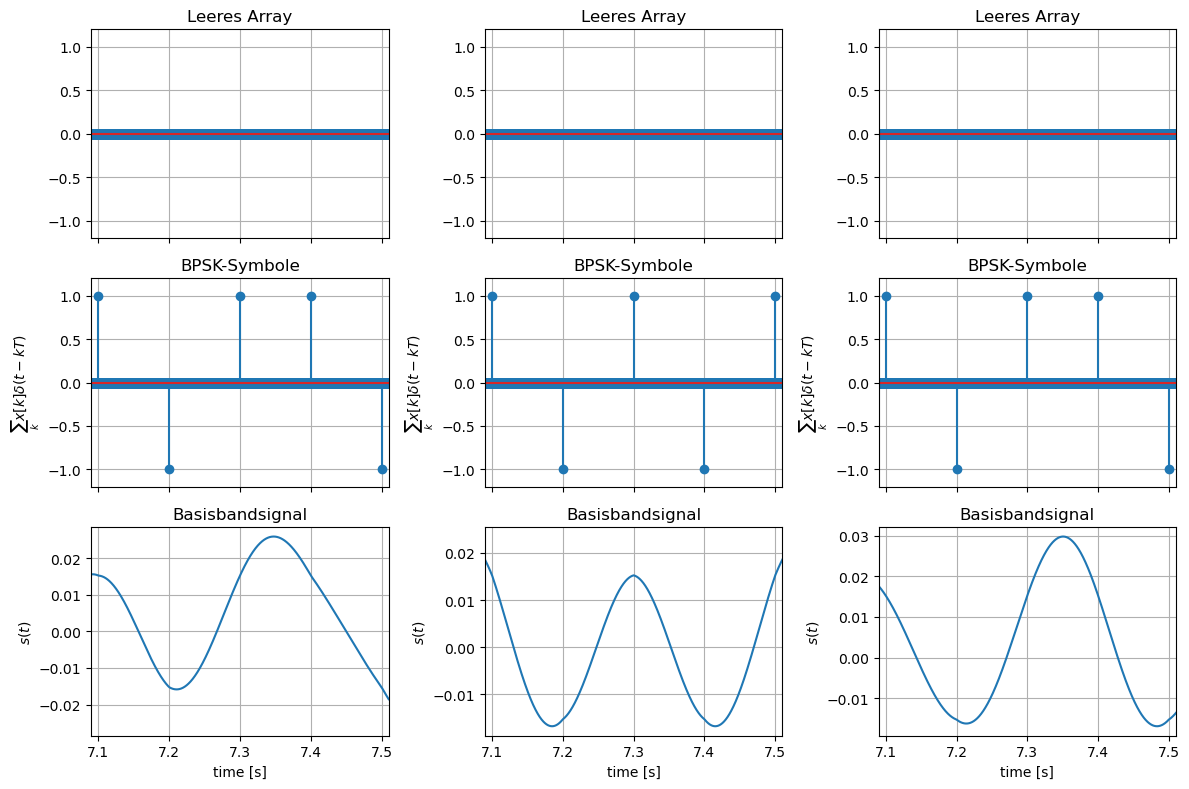

In [9]:
sym_up = [None] * num_carrier
tx_bb = [None] * num_carrier

d1 = 5                                  #number of symbols for zoom of plot
fig, axes = plt.subplots(nrows=3, ncols=num_carrier, sharex='col', figsize=(12, 8))
off = (np.size(preamble)+n_header*8)*n_up-int(n_up/10)      #Offset to plot info data, not preamble or data length info

for carrier_idx in range(num_carrier):
    #Upsample symbols and convolve with pulse shaping filter
    filter = get_filt(filt_type, n_up, K, T, beta)      #Get pulse shaping filter
    sym_up[carrier_idx] = np.zeros(np.size(bit[carrier_idx])*n_up)                #Create new array for zero-padded signal     
    sym_up[carrier_idx][::n_up]=sym[carrier_idx]                                  #Paste symbols into new array        
    tx_bb[carrier_idx] = scipy.signal.fftconvolve(filter,sym_up[carrier_idx])     #Create BB-signal by convolution with pulse shaping filter

    #Plot zoomed version of baseband signal for first d1 netto symbols
    t_plot = np.arange(0,np.size(tx_bb[carrier_idx])-1,1)/rate
    
    ax1 = axes[0, carrier_idx] if num_carrier > 1 else axes[0]
    ax1.stem(t_plot[off:off+d1*n_up],np.zeros((d1*n_up)))
    ax1.grid(True)
    ax1.set_title('Leeres Array')
    ax1.set_ylim(-1.2,1.2)

    ax2 = axes[1, carrier_idx] if num_carrier > 1 else axes[1]
    ax2.stem(t_plot[off:off+d1*n_up],sym_up[carrier_idx][off:off+d1*n_up])
    ax2.set_title('BPSK-Symbole')
    ax2.set_ylim(-1.2,1.2)
    ax2.set_ylabel('$\sum_k x[k] \\delta(t-kT)$')
    ax2.grid(True)

    ax3 = axes[2, carrier_idx] if num_carrier > 1 else axes[2]
    ax3.plot(t_plot[off:off+d1*n_up],tx_bb[carrier_idx][off+np.int32(K/2)*n_up:off+(d1+np.int32(K/2))*n_up])
    ax3.set_title('Basisbandsignal')
    ax3.set_xlim(off/n_up*T,((off+2*n_up/10)/n_up+(d1-1))*T)
    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('$s(t)$')
    ax3.grid(True)

    fig.tight_layout()
    fig.show()

Durch $s_\mathrm{BP}(t)=\mathrm{Re} \left\{ s(t) \mathrm{e}^{\mathrm{j}2\pi f_\mathrm{T} t}\right\}$ wird aus dem Basisbandsignal $s(t)$ das Bandpasssignal $s_\mathrm{BP}(t)$ erzeugt:

In [10]:
t = [None] * num_carrier
carrier = [None] * num_carrier
tx = [None] * num_carrier

for carrier_idx in range(num_carrier):
    #Convert BB -> BP
    t[carrier_idx] = np.linspace(0,np.size(tx_bb[carrier_idx])-1,np.size(tx_bb[carrier_idx]))/rate
    carrier[carrier_idx] = np.exp(1j*2*np.pi*f_t[carrier_idx]*t[carrier_idx])
    tx[carrier_idx] = np.real(tx_bb[carrier_idx] * carrier[carrier_idx]) 

Nun können wir die einzelnen Unterträger additiv überlagern

In [11]:
max_len = max(len(sublist) for sublist in tx)

# Add zeros after when the transmission of the previous data streams has ended
for carrier_idx in range(num_carrier):
    tx[carrier_idx] = np.pad(tx[carrier_idx], (0, max_len - len(tx[carrier_idx])), mode='constant')
    
t_sum = np.linspace(0,max_len-1,max_len)/rate
tx_sum = sum(tx)

Wir können nun das Basisbandsignal und das Bandpasssignal sowie deren Spektren plotten: 

C:\Users\Benedikt Geiger\AppData\Local\Temp\ipykernel_12556\4226696356.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_tx = cm.get_cmap('Pastel1', num_carrier)  # use tab10 with num_carrier distinct colors
C:\Users\Benedikt Geiger\AppData\Local\Temp\ipykernel_12556\4226696356.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_tx_bb = cm.get_cmap('Set1', num_carrier)  # use tab10 with num_carrier distinct colors
C:\Users\Benedikt Geiger\AppData\Local\Temp\ipykernel_12556\4226696356.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig

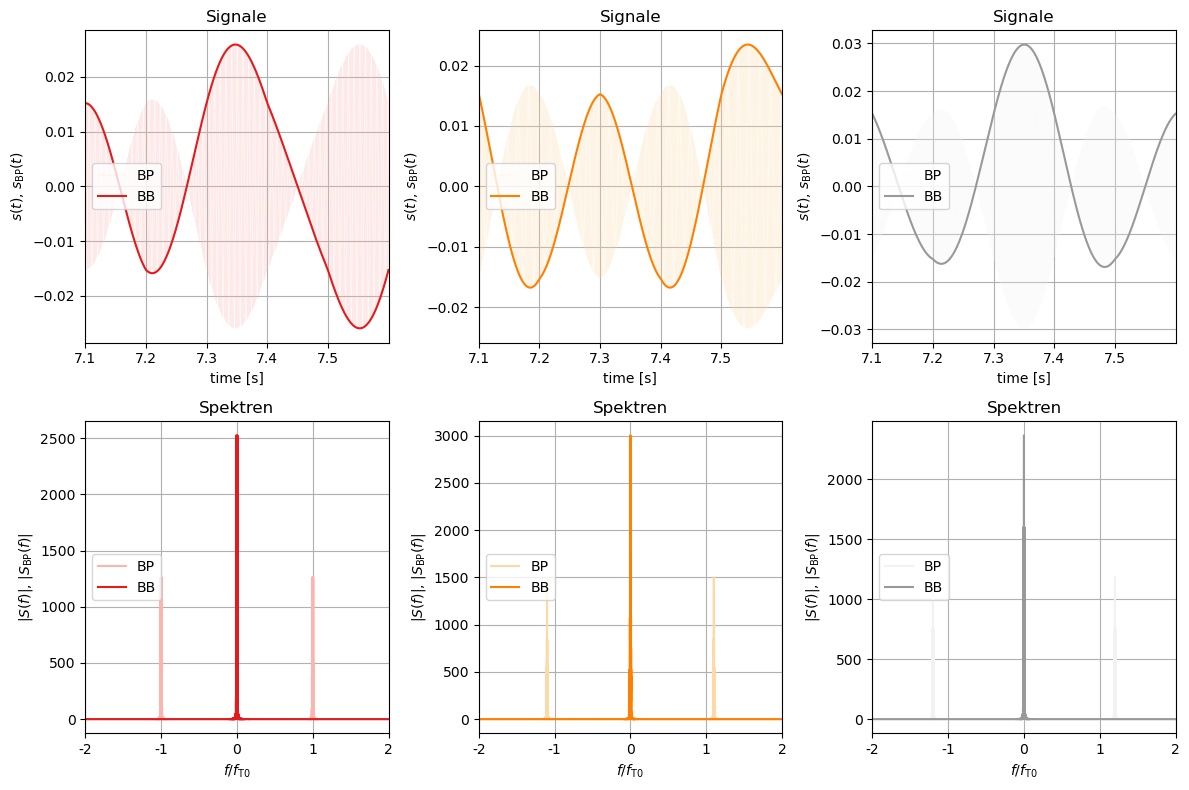

In [12]:
d2 = 5

fig, axes = plt.subplots(nrows=2, ncols=num_carrier, figsize=(12, 8))
cmap_tx = cm.get_cmap('Pastel1', num_carrier)  # use tab10 with num_carrier distinct colors
cmap_tx_bb = cm.get_cmap('Set1', num_carrier)  # use tab10 with num_carrier distinct colors
off = (np.size(preamble)+n_header*8)*n_up      #Offset to plot info data, not preamble or data length info

for carrier_idx in range(num_carrier):
    # Plot baseband and bandpass of first d2 netto data symbols
    ax1 = axes[0, carrier_idx] if num_carrier > 1 else axes[0]
    ax1.plot(t[carrier_idx][off:off+d2*n_up],tx[carrier_idx][off+np.int32(K/2)*n_up:off+(d1+np.int32(K/2))*n_up],label='BP',color=cmap_tx(carrier_idx),linewidth=0.1)
    ax1.plot(t[carrier_idx][off:off+d2*n_up],tx_bb[carrier_idx][off+np.int32(K/2)*n_up:off+(d1+np.int32(K/2))*n_up],label='BB',color=cmap_tx_bb(carrier_idx))
    ax1.grid(True)
    ax1.legend(loc='center left')
    ax1.set_xlim(off/n_up*T,(off/n_up+d2)*T)
    ax1.set_xlabel('time [s]')
    ax1.set_xticks(ticks=(np.arange(off/n_up,off/n_up+d2,1)*T),labels=(np.round(np.arange(off/n_up,off/n_up+d2,1)*T,1)))
    ax1.set_ylabel('$s(t)$, $s_\\mathrm{BP}(t)$')
    ax1.set_title('Signale')

    #Calculate spectra and normalize them to max. amplitude = 1, then plot everyhting
    S = np.abs(np.fft.fftshift(np.fft.fft(tx_bb[carrier_idx])))
    S_BP = np.abs(np.fft.fftshift(np.fft.fft(tx[carrier_idx])))

    ax2 = axes[1, carrier_idx] if num_carrier > 1 else axes[1]
    ax2.plot(np.linspace(-rate/2,rate/2,np.size(tx[carrier_idx]))/rate,S_BP,color=cmap_tx(carrier_idx), label='BP')
    ax2.plot(np.linspace(-rate/2,rate/2,np.size(tx_bb[carrier_idx]))/rate,S,color=cmap_tx_bb(carrier_idx),label='BB')
    ax2.grid(True)
    ax2.set_xlim(-2*(f_t[0]/rate),2*f_t[0]/rate)
    ax2.set_xticks(ticks=(np.array([-2,-1,0,1,2])*(f_t[0]/rate)),labels=(-2,-1,0,1,2))
    ax2.set_xlabel('$f/f_\\mathrm{T0}$')
    ax2.set_ylabel('|$S(f)$|, |$S_\\mathrm{BP}(f)$|')
    ax2.legend(loc='center left')
    ax2.set_title('Spektren')
    
fig.tight_layout()
fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Spektren')

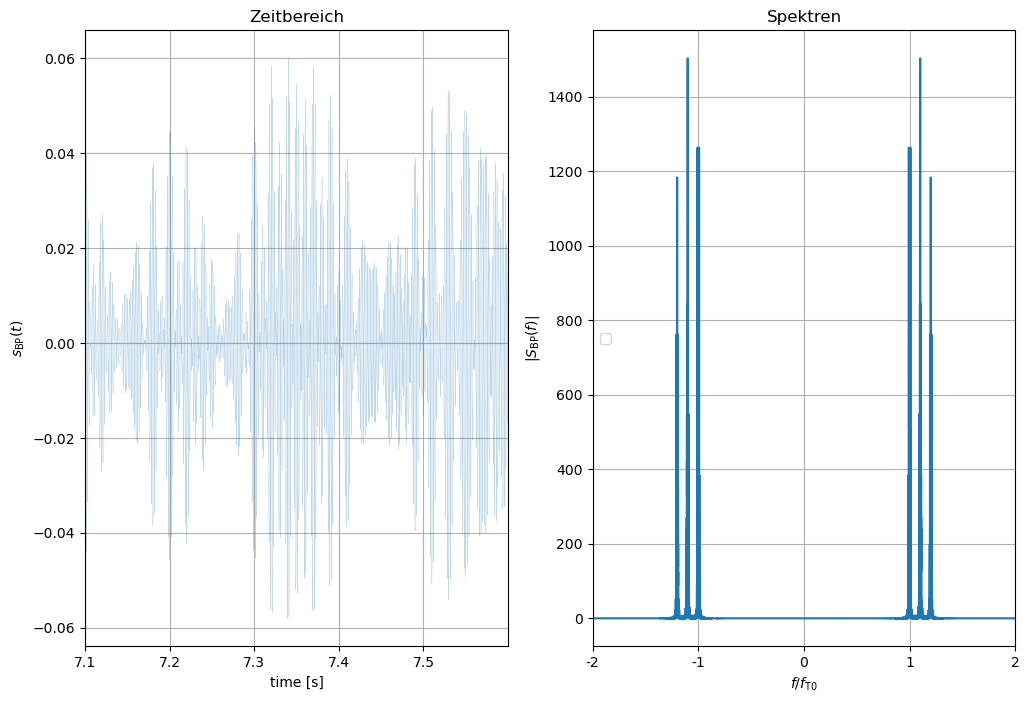

In [13]:
#Calculate spectra and normalize them to max. amplitude = 1, then plot everyhting
S_BP_sum = np.abs(np.fft.fftshift(np.fft.fft(tx_sum)))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
ax1.plot(t_sum[off:off+d2*n_up],tx_sum[off+np.int32(K/2)*n_up:off+(d1+np.int32(K/2))*n_up],linewidth=0.1)
ax1.grid(True)
ax1.set_xlim(off/n_up*T,(off/n_up+d2)*T)
ax1.set_xlabel('time [s]')
ax1.set_xticks(ticks=(np.arange(off/n_up,off/n_up+d2,1)*T),labels=(np.round(np.arange(off/n_up,off/n_up+d2,1)*T,1)))
ax1.set_ylabel('$s_\\mathrm{BP}(t)$')
ax1.set_title('Zeitbereich')

ax2.plot(np.linspace(-rate/2,rate/2,np.size(tx_sum))/rate,S_BP_sum)
ax2.grid(True)
ax2.set_xlim(-2*(f_t[0]/rate),2*f_t[0]/rate)
ax2.set_xticks(ticks=(np.array([-2,-1,0,1,2])*(f_t[0]/rate)),labels=(-2,-1,0,1,2))
ax2.set_xlabel('$f/f_\\mathrm{T0}$')
ax2.set_ylabel('|$S_\\mathrm{BP}(f)$|')
ax2.legend(loc='center left')
ax2.set_title('Spektren')

Wir speichern die Audio-Datei und können diese nun abspielen:

In [14]:
# Save audio signal and preamble
scaled = np.int16(tx_sum / np.max(np.abs(tx_sum)) * 32767)
write(path+'tx.wav', np.int32(rate), scaled)

# Now we can play our audio signal!
import IPython 
IPython.display.Audio(path+'tx.wav')

Hier kann das Audio-Signal nun übertragen werden, sprich von einem Lautsprecher abgespielt werden.
Unter linux ubuntu kann das Audio-Signal direkt mit dem Mikrofon aufgenommen werden mit z.B.  
$\texttt{arecord -r 44100  rx.wav}$.


Ist das Audiosignal aufgenommen, so kann es wieder importiert werden.
Wir plotten das empfangene Bandpasssignal:

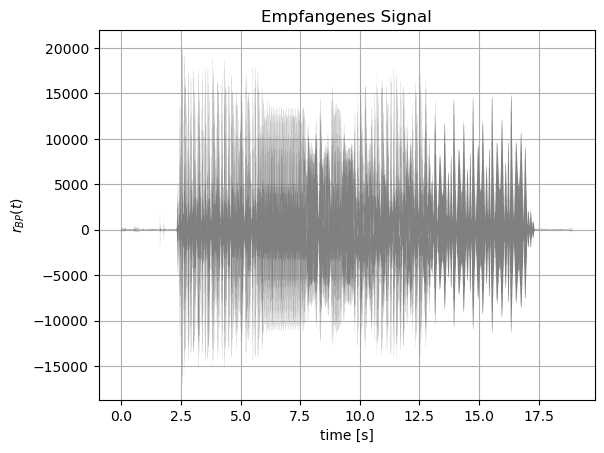

In [15]:
#Readout audio file and define audio-upsamling factor, load preamble
rate, audio = read(path+'rx.wav')

#Plot BB and BP signal
plt.close()
plt.plot(np.arange(0,np.size(audio),1)/rate,audio,label='BP',color='gray',linewidth=0.05)
plt.grid(True)
plt.xlabel('time [s]')
plt.ylabel('$r_{BP}(t)$')
plt.title('Empfangenes Signal')
plt.show()

Nach Empfang des Signals implementieren wir einen IQ-Demodulator.
Für die Inphasenkomponente $r_\mathrm{I}(t)$ wird das empfangene Bandpasssignal mit $\cos(2\pi f_\mathrm{T}t)$, für die Quadraturkomponente $r_\mathrm{Q}(t)$ mit $-\sin(2\pi f_\mathrm{T}t)$ multipliziert.
Anschließend werden Frequenzanteile bei $\pm 2f_\mathrm{T}$ durch das Matched-Filter $h(t)$ entfernt, wobei durch Reellwertigkeit und Symmetrie des Pulsformungsfilters $h(t)=g^{\ast} (\kappa T-t)=g(t)$ ist.
Danach werden beide Komponenten durch $r(t)=r_\mathrm{I}(t)+\mathrm{j}r_\mathrm{Q}(t)$ zum Empfangssignal im Basisband kombiniert:

C:\Users\Benedikt Geiger\AppData\Local\Temp\ipykernel_12556\4016998436.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


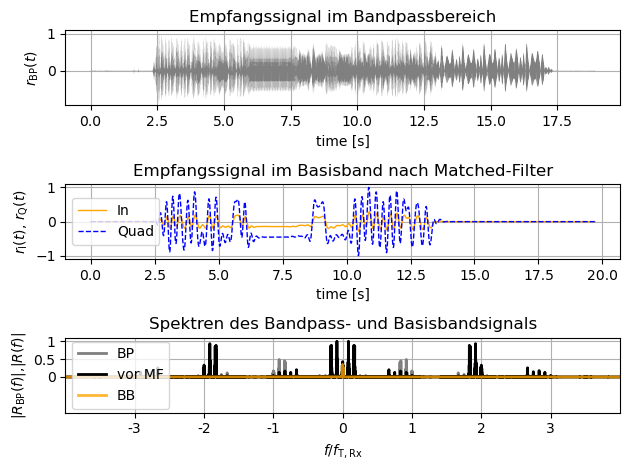

In [16]:
#Downconversion (IQ-Demoudlator)
t = np.linspace(0,np.size(audio)-1,np.size(audio))/rate
carrier_in = 2*np.cos(2*np.pi*f_t_Rx*t)
carrier_quad = -2*np.sin(2*np.pi*f_t_Rx*t)

r_I = audio*carrier_in        # Convert inphase component into baseband
r_Q = audio*carrier_quad        # Do same for quadrature component

# Matched-filtering
r_I_filt = scipy.signal.fftconvolve(r_I,filter/np.sum(filter))       #MF is applied
r_Q_filt = scipy.signal.fftconvolve(r_Q,filter/np.sum(filter))

rx_bb_filt = r_I_filt + 1j*r_Q_filt 

# Plot received signal and MF-version of it
fig, (ax1,ax2,ax3) = plt.subplots(3)

#Plot received signal
ax1.plot(np.arange(0,np.size(audio),1)/rate,audio/np.max(audio),label='BP',color='gray',linewidth=0.05)
ax1.set_xlabel('time [s]')
ax1.set_ylabel('$r_\mathrm{BP}(t)$')
ax1.grid(True)
ax1.set_title('Empfangssignal im Bandpassbereich')

#Plot MF-signal
sig_max = np.max(np.array([np.max(r_I_filt),np.max(r_Q_filt)]))
ax2.plot(np.arange(0,np.size(r_I_filt),1)/rate,r_I_filt/sig_max,label='In',color='orange',linewidth=1)
ax2.plot(np.arange(0,np.size(r_Q_filt),1)/rate,r_Q_filt/sig_max,label='Quad',color='blue',linewidth=1,linestyle='dashed')
ax2.set_xlabel('time [s]')
ax2.set_ylabel('$r_{\mathrm{I}}(t)$, $r_{\mathrm{Q}}(t)$')
ax2.grid(True)
ax2.legend(loc='center left')
ax2.set_title('Empfangssignal im Basisband nach Matched-Filter')

#Plot Spectra
R_BP = np.abs(np.fft.fftshift(np.fft.fft(audio)))       #Spectrum of received signal
R_mixed = np.abs(np.fft.fftshift(np.fft.fft(r_I)))+np.abs(np.fft.fftshift(np.fft.fft(1j*r_Q)))    #Spectrum of received signal after mixing with f_T
R = np.abs(np.fft.fftshift(np.fft.fft(rx_bb_filt)))     #Spectrum after Matched-Filter was applied

ax3.plot(np.linspace(-rate/2,rate/2,np.size(R_BP))/rate,R_BP,color='gray', label='BP',linewidth=2)
ax3.plot(np.linspace(-rate/2,rate/2,np.size(R_mixed))/rate,R_mixed,color='black', label='vor MF', linewidth= 2)
ax3.plot(np.linspace(-rate/2,rate/2,np.size(R))/rate,R,color='orange',label='BB',alpha=0.8, linewidth=2)
ax3.grid(True)
ax3.set_xlim(-4*(f_t_Rx/rate),4*f_t_Rx/rate)
ax3.set_xticks(ticks=(np.arange(-3,4,1)*(f_t_Rx/rate)),labels=(np.arange(-3,4,1)))
ax3.set_xlabel('$f/f_\\mathrm{T, Rx}$')
ax3.set_ylabel('|$R_{\mathrm{BP}}(f)$|,|$R(f)$|')
maxi = np.max(np.array([np.max(R),np.max(R_BP),np.max(R_mixed)]))
ax3.set_ylim(-1*maxi,1.1*maxi)
ax3.set_yticks(ticks=(0,maxi/2,maxi),labels=(0,0.5,1))
ax3.legend(loc='center left')
ax3.grid(True)
ax3.set_title('Spektren des Bandpass- und Basisbandsignals')


fig.tight_layout()
fig.show()


Nun "suchen" wir im Empfangssignal die Präambel. Dies können wir durch eine Korrelation des Empfangssignals mit der dem Empfänger bekannten Präambel realisieren.
Da das Empfangssignal durch das Matched-Filter modifiziert wurde, muss die Präambel auch durch das Matched-Filter modifiziert werden.
Danach kann die Korrelation der beiden Signale durch eine Multiplikation im Frequenzbereich realisiert werden.

Das Maximum der Absolutwerte der Korrelation $\texttt{pre\_max}$ gibt nun sowohl die Position der Präambel im Empfangssignal als auch den Abtastpunkt nach dem Matched-Filter an.
Die weiteren Symbole $y_i$ liegen nun auf den Samples $\texttt{pre\_max} +m\, \texttt{n\_up},\; m \in \mathbb{N}$, und können ausgelesen werden.



C:\ProgramData\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Benedikt Geiger\AppData\Local\Temp\ipykernel_12556\3778637565.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


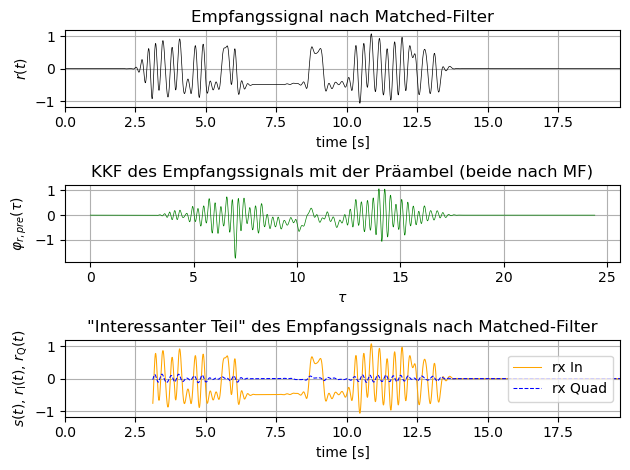

In [17]:
#Get pulse-shaped and matched-filtered preamble
pre_up = np.zeros(np.size(preamble)*n_up)
pre_up[::n_up]= (-1)**preamble
pre_up = scipy.signal.fftconvolve(filter,pre_up)     #pulse shaping
pre_up_MF = scipy.signal.fftconvolve(filter,pre_up)  #matched-filtering

#Identify preamble in down-converted rx-data 
rx_pre = scipy.signal.fftconvolve(np.flip(pre_up_MF),rx_bb_filt)
pre_max = np.argmax(np.abs(rx_pre))
if filt_type == 'rrc':
    pre_start = pre_max- np.int32(np.size(preamble)+K)*n_up
else:           #rect has K=1
    pre_start = pre_max- np.int32(np.size(preamble)+1)*n_up

#Readout "important part" of data (starting at preamble) out of matched-filtered rx-baseband signal
rx = rx_bb_filt[pre_start:]     #Keep data from start of preamble

# Plot MF-version and cut out version of received signal and correlation with preamble
fig, (ax2,ax3,ax4) = plt.subplots(3)


#Plot MF-signal
ax2.plot(np.arange(0,np.size(rx_bb_filt),1)/rate,rx_bb_filt/np.max(rx_bb_filt),color='k',linewidth=0.5)
ax2.set_xlabel('time [s]')
ax2.set_ylabel('$r(t)$')
ax2.grid(True)
ax2.set_xlim(0,np.size(rx_bb_filt)/rate)
ax2.set_title('Empfangssignal nach Matched-Filter')

#Plot Convolution of MF-signal with preamble to show peak detection
ax3.plot(np.arange(0,np.size(rx_pre),1)/rate,rx_pre/np.max(rx_pre),color='green',linewidth=0.5)
ax3.set_xlabel('$\\tau$')
ax3.set_ylabel('$\\varphi_{r,pre}(\\tau)$')
ax3.set_title('KKF des Empfangssignals mit der Präambel (beide nach MF)')
ax3.grid(True)

#Plot MF-signal starting at detected preamble
#ax4.plot(np.arange(pre_start-K/2*n_up,pre_start-K/2*n_up+np.size(tx_bb),1)/rate,tx_bb/np.max(tx_bb),color='k',linewidth=0.75,label='tx')
ax4.plot(np.arange(pre_start,pre_start+np.size(rx),1)/rate,np.real(rx/np.max(rx)),color='orange',linewidth=0.75,label='rx In')
ax4.plot(np.arange(pre_start,pre_start+np.size(rx),1)/rate,np.imag(rx/np.max(rx)),color='blue',linewidth=0.75,label='rx Quad', linestyle='dashed')
ax4.legend(loc='center right')
ax4.set_xlabel('time [s]')
ax4.set_ylabel('$s(t)$, $r_{\mathrm{I}}(t)$, $r_{\mathrm{Q}}(t)$')
ax4.grid(True)
ax4.set_xlim(0,np.size(rx_bb_filt)/rate)
ax4.set_title('"Interessanter Teil" des Empfangssignals nach Matched-Filter')

fig.tight_layout()
fig.show()


#Readout at sampling points 
sym = rx[np.size(preamble)*n_up:][0::n_up]


Am Sender hatten wir durch die BPSK-Modulation lediglich auf der Inphasenkomponenten Werte ungleich Null, d.h. $s_\text{Q}(t)=0$. 
Durch die Übertragung und somit die Laufzeit des Signals kann es allerdings zu einem konstanten Phasenoffset im Empfangssignal kommen, welchen man im Empfänger an $r_\text{Q}(t)\neq 0$ erkennt.
Zur Korrektur der Phase nutzen wir den Viterbi-and-Viterbi Algorithmus, der uns für eine BPSK-Modulation den Phasenoffset durch  $\hat{\varphi} = \frac12 \arg \left( \sum_i \left( \frac{y_i}{|y_i|} \right)^2\right)$ schätzt, wobei $y_i$ die Samples nach Matched-Filterung sowie Abtastung des Basisbandsignals sind. Danach kann die Phase durch eine simple Drehung in der komplexen Ebene korrigiert werden. 

Geschätzter Phasenoffset: 78.43666029869382 °


[]

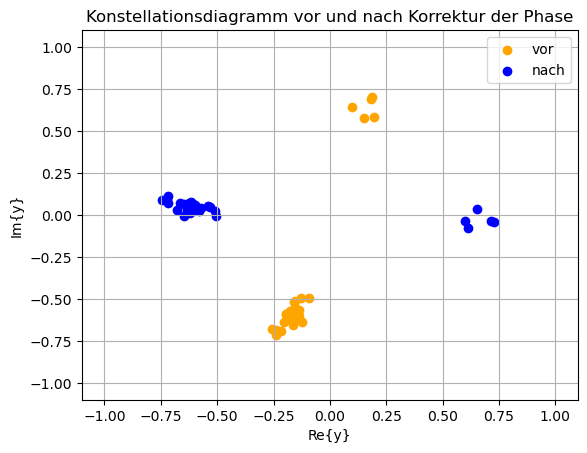

In [18]:
#Phase estimation and correction using Viterbi-Viterbi
phase_est = 1/2*np.angle(np.sum((sym/np.abs(sym))**2))      #Estimate phase
sym_phase = sym * np.exp(-1j*phase_est)                     #Correct phase                                                 
print('Geschätzter Phasenoffset:',np.rad2deg(phase_est),'°')

max_sym = np.max([np.max(np.abs(sym)),np.max(np.abs(sym_phase))])
plt.scatter(np.real(sym[0:n_header*8])/max_sym,np.imag(sym[0:n_header*8])/max_sym,color='orange',label='vor')
plt.scatter(np.real(sym_phase[0:n_header*8])/max_sym,np.imag(sym_phase[0:n_header*8])/max_sym,color='blue',label='nach')
plt.legend()
plt.title('Konstellationsdiagramm vor und nach Korrektur der Phase')
plt.xlabel('Re{y}')
plt.ylabel('Im{y}')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.grid(True)
plt.plot()


Der Viterbi-and-Viterbi Algorithmus löst keine Phasenmehrdeutigkeit auf, d.h. nach der Phasenkorrektur befinden sich nur noch im Inphasenteil Signalanteile, keine mehr in der Quadraturkomponente. Nun muss noch geprüft werden, ob bei der Übertragung und Phasenkorrektur die Inphasenkomponente um 180° gedreht wurde.
Dies kann durch Vergleich mit der BPSK-modulierten Präambel gemacht werden. Besitzen im Mittel mehr als die Hälfte der Symbole dasselbe Vorzeichen, dann schätzen wir eine korrekte Phase. Unterscheiden sich mehr als die Hälfte der Symbole im Vorzeichen, so schätzen wir einen Phasenoffset von 180° und korrigieren diesen.

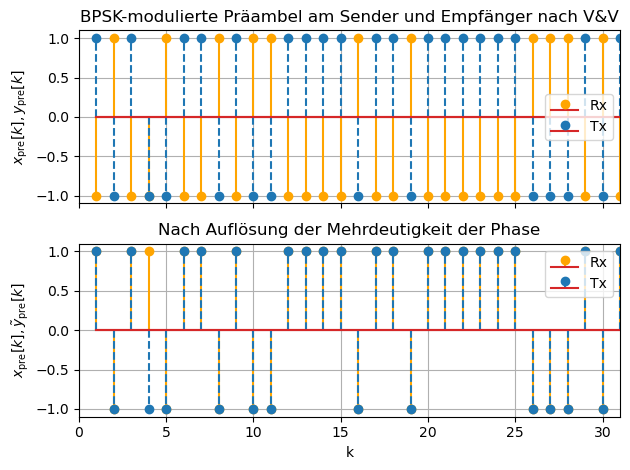

In [19]:

# Check using preamble if phase ambiguities are resolved --> 180° possible
sym_pre_rx = np.sign(np.real(rx[0:np.size(preamble-1)*n_up][0::n_up]))  #Estimate received symbols by ML-decision
sym_pre_tx = (-1)**preamble                     #BPSK-modulated preamble
phase_ambi = np.sum(sym_pre_tx*sym_pre_rx)      #Preamble: tx=rx? If no, then 180° phase shift
sym_pre_rx_corr = sym_pre_rx                    #Make copy for plot to show phase correction
if phase_ambi <0:                               #If phase shift <0, then correct data by 180°
    sym_phase = -sym_phase                      #Correct phase of data by 180°
    sym_pre_rx_corr = -sym_pre_rx               #Correct phase of preamble for plot


fig, (ax1,ax2) = plt.subplots(2,sharex=True)

ax1.stem(np.arange(1,np.size(preamble)+1,1),sym_pre_rx, 'orange',label='Rx')
ax1.stem(np.arange(1,np.size(preamble)+1,1),sym_pre_tx, 'k',label='Tx',linefmt='--')
ax1.set_xlim(0,np.size(preamble+2))
ax1.set_ylim(-1.1,1.1)
ax1.set_title('BPSK-modulierte Präambel am Sender und Empfänger nach V&V')
ax1.legend()
ax1.set_ylabel('$x_\mathrm{pre}[k],y_\mathrm{pre}[k]$')
ax1.grid(True)

ax2.stem(np.arange(1,np.size(preamble)+1,1),sym_pre_rx_corr, 'orange' ,label='Rx')
ax2.stem(np.arange(1,np.size(preamble)+1,1),sym_pre_tx, 'k',label='Tx',linefmt='--')
ax2.set_title('Nach Auflösung der Mehrdeutigkeit der Phase')
ax2.set_xlim=(0,np.size(preamble+2))
ax2.set_ylim([-1.1,1.1])
ax2.legend()
ax2.grid(True)
ax2.set_xlabel('k')
ax2.set_ylabel('$x_\mathrm{pre}[k],\\tilde{y}_\mathrm{pre}[k]$')

fig.tight_layout()

Als letzten Schritt werden die ersten $8\cdot n_\mathrm{header}$ BPSK-Symbole nach der Präambel genutzt, um die Länge der Nachricht $\texttt{num\_chars}$ zu bestimmen. 
Dazu werden diese dem Kanaldecoder übergeben, der mittels einer Mehrheitsentscheidung den $n_\mathrm{header}$-Wiederholungscode dekodiert.
Die eigentlichen Nutzdaten liegen nun in den folgenden $\texttt{num\_chars} \cdot 8 \cdot n_\mathrm{data}$ BPSK-Symbolen.
Nach Entscheidung der verrauschten BPSK-Symbole auf Bits wird zuerst der genutzte $n_\mathrm{data}$-Wiederholungscode und danach die Textnachricht mit UTF-8 dekodiert.

In [20]:
# Readout number of transmitted characters (first n*8 bits after preamble) and limit received message 
num_chars = np.int32(np.heaviside(-np.real(sym_phase[0:n_header*8]),0))
num_chars = rep_decode(num_chars,n_header)             #decode repetition code
num_chars = np.int32(num_chars.dot(1 << np.arange(num_chars.shape[-1]-1,-1,-1)))
sym_data = sym_phase[n_header*8:n_header*8+8*n_data*num_chars] #each char: 8*n_data bits

#Decode to bits and then decode bits
bits = np.int32(np.heaviside(-np.real(sym_data),0))
bits = rep_decode(bits,n_data)
message_rx = bits2text(bits)

print(message_rx)


Kind
